In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sys
import os
sys.path.append(os.path.abspath(".."))
from utils import *
plt.rcParams['font.family'] = 'serif'

# Set the font used for math expressions to LaTeX
plt.rcParams["mathtext.fontset"] = "cm"

In [2]:
year = 2023
rating_data_path = '/share/garg/311_data/sb2377_a_data/rodents/Rodent_Inspection_20240404.csv'
report_data_path = '/share/garg/311_data/sb2377/clean_codebase/data_{}.csv'.format(year)
covars_path = '/share/garg/311_data/sb2377/clean_codebase/tract_demographics.csv'
save_path = '/share/garg/311_data/sb2377/clean_codebase/processed_rodents_{}.csv'.format(year)

In [3]:
complaint_type = 'Rodent'
reported_label = 'reported'
rename_map = {'INSPECTION_DATE': 'date'}

In [4]:
covariates_arr = pd.read_csv(covars_path)
df = pd.read_csv(rating_data_path)
df_311 = pd.read_csv(report_data_path)

/share/pierson/tmp_directory_location_please_read_readme/sb2377_tmp/ipykernel_4137395/1621718016.py:3: DtypeWarning: Columns (9,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_311 = pd.read_csv(report_data_path)


In [5]:
census_gdf, final_graph, census_gdf_raw = generate_graph_census()
census_gdf = census_gdf.to_crs('EPSG:2263')

Using the default year of 2021
Using FIPS code '36' for input 'NY'
Using FIPS code '061' for input 'New York'
Using FIPS code '005' for input 'Bronx'
Using FIPS code '047' for input 'Kings'
Using FIPS code '081' for input 'Queens'
Using FIPS code '085' for input 'Richmond'


In [6]:
# process rating data
# rename columns
df = df.rename(columns=rename_map)

# process date
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y %I:%M:%S %p')
df['year'] = df['date'].dt.year
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df.loc[(df['month'] == 1) & (df['week'] > 50), 'week'] = 0 # start first week at 0 (instead of previous year's indexing)
one_year_df = df[df['year'] == year]

# get only rat inspections
one_year_df = one_year_df[one_year_df['INSPECTION_TYPE'].isin(['Initial', 'Compliance'])]

# remove all rows without a BBL
one_year_df = one_year_df.dropna(subset=['BBL', 'BORO_CODE', 'BLOCK', 'LOT'])

# get correct BBL
# BBL = BORO_CODE + BLOCK + LOT
one_year_df.rename(columns={'BBL': 'incorrect_BBL'}, inplace=True)
def compose_bbl(row):
    boro_code = str(row['BORO_CODE'])
    block = str(row['BLOCK']).zfill(5)  # Zero-pad the block to 5 digits
    lot = str(row['LOT']).zfill(4)      # Zero-pad the lot to 4 digits
    return boro_code + block + lot

# Apply the function to create BBL
one_year_df['BBL'] = one_year_df.apply(compose_bbl, axis=1)
one_year_df['BBL'] = one_year_df['BBL'].astype(int)
one_year_df['incorrect_BBL'] = one_year_df['incorrect_BBL'].astype(int)

# remove all rows with nan ratings
one_year_df = one_year_df.dropna(subset=['RESULT'])

# get census tract information
one_year_df = one_year_df.dropna(subset=['LATITUDE', 'LONGITUDE'])
one_year_df = one_year_df[(one_year_df['LATITUDE'] != 0) & (one_year_df['LONGITUDE'] != 0)]
one_year_gdf = gpd.GeoDataFrame(one_year_df,
                                geometry=gpd.points_from_xy(one_year_df.LONGITUDE, one_year_df.LATITUDE),
                                crs='EPSG:4326')
one_year_gdf = gpd.sjoin(one_year_gdf.to_crs('EPSG:2263').reset_index(drop=True), census_gdf.to_crs('EPSG:2263'), how='inner', op='intersects')
# remove all rows where lat/lon location for different BBLs map to multiple different GEOIDs (because unclear what to GEOID to choose later on when we discretize by BBL)
bbl_map = one_year_gdf[['BBL', 'GEOID']].drop_duplicates()
duplicated_bbl = bbl_map[bbl_map.duplicated(subset=['BBL'], keep=False)]['BBL'].unique()
one_year_gdf = one_year_gdf[~one_year_gdf['BBL'].isin(duplicated_bbl)]

# apply proactive inspection heuristic
dfs = []
for w in sorted(one_year_gdf['week'].unique()):
    week_df = one_year_gdf[one_year_gdf['week'] == w].copy()
    tract_count = week_df['GEOID'].value_counts()
    week_df['tract_count'] = week_df['GEOID'].map(tract_count)
    week_df['tract_percentile'] = week_df['tract_count'].rank(method='average').div(len(week_df['tract_count']))
    dfs.append(week_df)
    
one_year_gdf = pd.concat(dfs)

# keep only the proactive reports
all_rating_df = one_year_gdf
one_year_gdf = one_year_gdf[one_year_gdf['tract_percentile'] >= 0.5]
proactive_rating_df = one_year_gdf

# convert condition to numeric score
score_map = {'Rat Activity':0, 'Failed for Other R':1, 'Passed':2}
one_year_gdf['score'] = one_year_gdf['RESULT'].map(score_map)
one_year_gdf = one_year_gdf.groupby(['BBL', 'week', 'GEOID'])['score'].mean().reset_index()

rating_df = one_year_gdf

/share/pierson/conda_virtualenvs/networks_underreporting_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/share/pierson/conda_virtualenvs/networks_underreporting_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [7]:
# process reporting data
# get data for type
type_df = df_311[df_311['Complaint Type'] == complaint_type]
type_df['Created Date'] = pd.to_datetime(type_df['Created Date'])
type_df['week'] = type_df['Created Date'].dt.isocalendar().week
type_df['month'] = type_df['Created Date'].dt.month
type_df.loc[(type_df['month'] == 1) & (type_df['week'] > 50), 'week'] = 0 # start first week at 0 (instead of previous year's indexing)

# remove all rows without a BBL
type_df = type_df.dropna(subset=['BBL'])
type_df = type_df[type_df['BBL'] != 0]
type_df['BBL'] = type_df['BBL'].astype(int)

# process location
type_df = type_df[~(type_df.Latitude.isna()|type_df.Longitude.isna())]
type_gdf = gpd.GeoDataFrame(type_df,
                            geometry=gpd.points_from_xy(type_df.Longitude, type_df.Latitude),
                            crs='EPSG:4326')

# get census tract information
type_gdf = gpd.sjoin(type_gdf.to_crs('EPSG:2263').reset_index(drop=True), census_gdf.to_crs('EPSG:2263'), how='inner', op='intersects')
type_gdf['GEOID'] = type_gdf['GEOID'].astype(int)
type_gdf = type_gdf.to_crs('EPSG:2263')

reports_df = type_gdf

# only get reports in a BBL with an inspection
rating_bbl = set(rating_df['BBL'].unique())
inspected_reports_df = reports_df[reports_df['BBL'].isin(rating_bbl)]

/share/pierson/tmp_directory_location_please_read_readme/sb2377_tmp/ipykernel_4137395/2913533532.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  type_df['Created Date'] = pd.to_datetime(type_df['Created Date'])
/share/pierson/tmp_directory_location_please_read_readme/sb2377_tmp/ipykernel_4137395/2913533532.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_df['Created Date'] = pd.to_datetime(type_df['Created Date'])
/share/pierson/tmp_directory_location_please_read_readme/sb2377_tmp/ipykernel_4137395/2913533532.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [8]:
# create num finegrained entities x num weeks full T and r dataset
inspected_reports_df['finegrained_id'] = inspected_reports_df['BBL']
rating_df['finegrained_id'] = rating_df['BBL']
finegrained_entities = rating_df['finegrained_id'].unique()

dfs = []
for i in sorted(inspected_reports_df['week'].unique()):
    data = pd.DataFrame()
    data['finegrained_id'] = finegrained_entities
    data['report_week'] = i
    dfs.append(data)
    
all_data = pd.concat(dfs)

# add in T labels
# set T = 1 for instances where there is a complaint
inspected_reports_df['report_week'] = inspected_reports_df['week']
inspected_reports_df = inspected_reports_df[['finegrained_id', 'report_week']].drop_duplicates()
inspected_reports_df['reported'] = 1
all_data = pd.merge(all_data, inspected_reports_df, on=['finegrained_id', 'report_week'], how='left')
all_data['reported'] = all_data['reported'].fillna(0)

# add in rating data
rating_df['rating_week'] = rating_df['week']
rating_df['report_week'] = rating_df['week']
rating_subset_df = rating_df[['finegrained_id', 'score', 'rating_week', 'report_week']].drop_duplicates()
all_data = pd.merge(all_data, rating_subset_df, on=['finegrained_id', 'report_week'], how='left')

# assume constant rating until next inspection 
all_data.sort_values(by=['finegrained_id', 'report_week'], inplace=True)
all_data['score'] = all_data.groupby('finegrained_id')['score'].ffill()
all_data['rating_week'] = all_data.groupby('finegrained_id')['rating_week'].ffill()
all_data = all_data[::-1]
all_data['score'] = all_data.groupby('finegrained_id')['score'].ffill()
all_data['rating_week'] = all_data.groupby('finegrained_id')['rating_week'].ffill()
all_data = all_data[::-1]

# add in demographic data
all_data = pd.merge(all_data, rating_df[['finegrained_id', 'GEOID']].drop_duplicates(), on=['finegrained_id'], how='left')
all_data['GEOID'] = all_data['GEOID'].astype(int)
all_data = pd.merge(all_data, covariates_arr, on=['GEOID'], how='left')

# add in meta data
all_data['rating_week_of_year'] = all_data['rating_week']
all_data['report_week_of_year'] = all_data['report_week']

# get z-scored ratings
all_data['normalized_score'] = (all_data['score'] - all_data['score'].mean()) / all_data['score'].std()

/share/pierson/conda_virtualenvs/networks_underreporting_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/share/pierson/conda_virtualenvs/networks_underreporting_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [9]:
assert(len(finegrained_entities) * len(inspected_reports_df['report_week'].unique()) == len(all_data))

In [10]:
len(all_data)

3558420

In [11]:
assert(len(all_data[all_data.isna().any(axis=1)]) == 0)

In [12]:
all_data.to_csv(save_path)

In [11]:
# evaluate mean rating with and without a report
mean_1 = all_data[(all_data[reported_label] == 1)]['score'].mean()
error_1 = all_data[(all_data[reported_label] == 1)]['score'].std() / len(all_data)
mean_0 = all_data[(all_data[reported_label] == 0)]['score'].mean()
error_0 = all_data[(all_data[reported_label] == 0)]['score'].std() / len(all_data)
print('Mean rating of tracts with a report = {}, without a report = {}'.format(mean_1, mean_0))
print('95% CIs rating of tracts with a report = [{}, {}], without a report = [{}, {}]'.format(mean_1 - 1.96 * error_1, mean_1 + 1.96 * error_1, mean_0 - 1.96 * error_0, mean_0 + 1.96 * error_0))

Mean rating of tracts with a report = 1.099134236242071, without a report = 1.6714986423894718
95% CIs rating of tracts with a report = [1.0991337835704886, 1.0991346889136535], without a report = [1.6714983061909259, 1.6714989785880177]


Optimization terminated successfully.
         Current function value: 0.018093
         Iterations 12


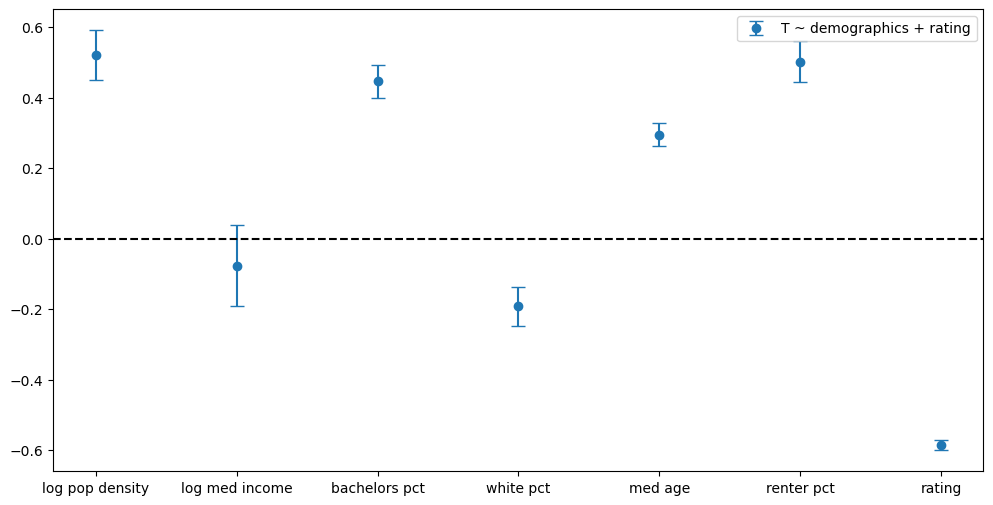

In [12]:
# run a regression of T ~ demographics + rating
covariates = ['log pop density',
              'log med income',
              'bachelors pct',
              'white pct',
              'med age',
              'renter pct'
             ]

normalized_covariates = ['normalized_log_population_density',
                         'normalized_log_income_median',
                         'normalized_education_bachelors_pct',
                         'normalized_race_white_nh_pct',
                         'normalized_age_median',
                         'normalized_households_renteroccupied_pct',
                         'normalized_score'
                        ]

plt.figure(figsize=(12, 6))

y_label = reported_label
formula = y_label + ' ~ '
for c in normalized_covariates:
    formula += c + ' + '
formula = formula[:-3]

fit = sm.Logit.from_formula(formula, data = all_data).fit()
fit.summary()
coefficients = fit.params.to_numpy()[-7:]
conf_intervals = fit.conf_int().to_numpy()[-7:, :]
plt.errorbar(x=covariates + ['rating'], y=coefficients, 
             yerr=[coefficients - conf_intervals[:,0], conf_intervals[:,1] - coefficients], capsize=5, fmt='o', label='T ~ demographics + rating')

plt.axhline(0, color='black', linestyle='--')  # Horizontal dashed line at y=0
plt.legend()
plt.show()

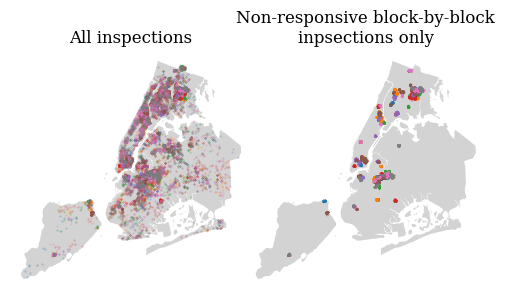

In [11]:
# create plot with proactive + reactive inspections vs only proactive inspections (using heuristic defined above)
projected_crs = 'EPSG:2263'
nodata_color = 'lightgray'
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# create outline and shading for graph
df_census = pd.read_csv('/share/garg/311_data/sb2377/nyc_census_graph.csv')
df_census['geometry'] = df_census['geometry'].apply(wkt.loads)
gdf_census = gpd.GeoDataFrame(df_census, geometry='geometry', crs='EPSG:4326')
nyc_boroughs = gpd.read_file('/share/garg/gs665/networks_underreporting/d01_data/d01_raw/d02_spatial-data/NYC-boroughs/NYC-boroughs.shp')
nyc_boundary = gpd.GeoDataFrame(geometry=[nyc_boroughs.unary_union], crs=nyc_boroughs.crs).to_crs(gdf_census.crs)

# Plot the base GeoDataFrame without the explicit boundary plot
base_gdf = nyc_boundary
base_gdf.to_crs(projected_crs).plot(ax=ax[0], color=nodata_color, linewidth=0, zorder=0)
base_gdf.to_crs(projected_crs).plot(ax=ax[1], color=nodata_color, linewidth=0, zorder=0)

# only plot inspections from first four weeks of the data
small_all_rating_df = all_rating_df[all_rating_df['week'] <= 8]
small_proactive_rating_df = proactive_rating_df[proactive_rating_df['week'] <= 8]

# Get unique week values
unique_weeks = sorted(small_all_rating_df['week'].unique())

# Create a color dictionary to assign a color to each unique week value
color_dict = {week: plt.cm.tab10(i) for i, week in enumerate(unique_weeks)}

# Plot the GeoDataFrame
all_rating_gdf = gpd.GeoDataFrame(small_all_rating_df, geometry=gpd.points_from_xy(small_all_rating_df.LONGITUDE, small_all_rating_df.LATITUDE), crs='EPSG:4326')
all_rating_gdf = all_rating_gdf.to_crs(projected_crs)
proactive_rating_gdf = gpd.GeoDataFrame(small_proactive_rating_df, geometry=gpd.points_from_xy(small_proactive_rating_df.LONGITUDE, small_proactive_rating_df.LATITUDE), crs='EPSG:4326')
proactive_rating_gdf = proactive_rating_gdf.to_crs(projected_crs)

for week, color in color_dict.items():
    all_rating_gdf[all_rating_gdf['week'] == week].plot(ax=ax[0], color=color, label=f'Week {week}', alpha=0.5, markersize=0.1, aspect=1)
    proactive_rating_gdf[proactive_rating_gdf['week'] == week].plot(ax=ax[1], color=color, label=f'Week {week}', alpha=0.5, markersize=0.11, aspect=1)
    
# # Add legend with larger icons
# legend = ax[0].legend(markerscale=20, loc='upper left', fontsize=12, bbox_to_anchor=(-0.1, 1))

# # Increase alpha of legend markers
# for handle in legend.legendHandles:
#     handle.set_alpha(1)

# Remove axes labels
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

# Remove the axes frame
ax[0].set_frame_on(False)
ax[1].set_frame_on(False)

ax[0].set_title('All inspections', fontsize=12)
ax[1].set_title('Non-responsive block-by-block\ninpsections only', fontsize=12)

# Save the plot
plt.tight_layout()
plt.subplots_adjust(wspace=-0.3)
plt.savefig("/home/sb2377/gnn_crowdsourced_data/figures/random_inspections.png", dpi=1200, bbox_inches="tight")